In [23]:
import pandas as pd
import numpy as np
import librosa
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
def train_with_10fold(model, name, data_dir='../data/pca'):
    accuracies = []
    all_preds = []
    all_labels = []

    for test_id in range(10):
        dfs = []
        for i in range(10):
            if i != test_id:
                df = pd.read_csv(f'{data_dir}/fold{i}.csv')
                dfs.append(df)
        train_df = pd.concat(dfs, ignore_index=True)
        test_df = pd.read_csv(f'{data_dir}/fold{test_id}.csv')

        # X, y
        X_train, y_train = train_df.drop('label', axis=1), train_df['label']
        X_test, y_test = test_df.drop('label', axis=1), test_df['label']

        # 訓練 & 評估
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        all_preds.extend(y_pred)
        all_labels.extend(y_test)

        print(f'Fold {test_id} Accuracy: {acc:.4f}')

    print(f'\nAverage Accuracy: {np.mean(accuracies):.4f}')
    print(f'Total: {len(all_labels)}')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (10-Fold CV) Using {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(classification_report(all_labels, all_preds))

    return all_preds, all_labels


Fold 0 Accuracy: 0.4868
Fold 1 Accuracy: 0.5191
Fold 2 Accuracy: 0.5103
Fold 3 Accuracy: 0.4889
Fold 4 Accuracy: 0.5310
Fold 5 Accuracy: 0.3876
Fold 6 Accuracy: 0.5215
Fold 7 Accuracy: 0.4926
Fold 8 Accuracy: 0.5490
Fold 9 Accuracy: 0.5723

Average Accuracy: 0.5059
Total: 8732


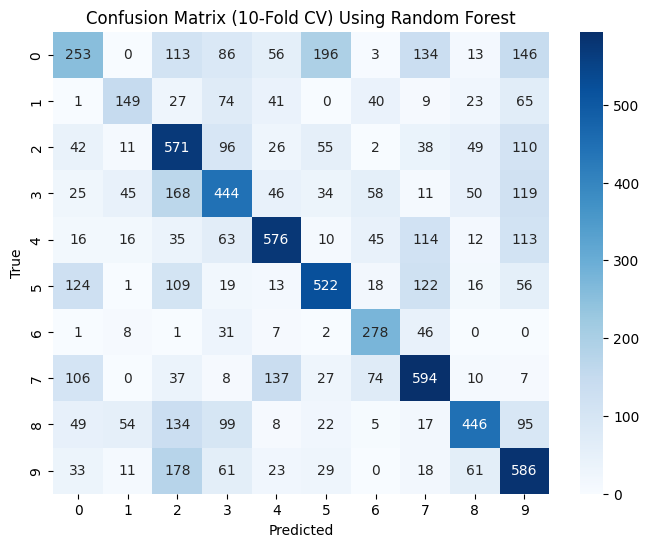

              precision    recall  f1-score   support

           0       0.39      0.25      0.31      1000
           1       0.51      0.35      0.41       429
           2       0.42      0.57      0.48      1000
           3       0.45      0.44      0.45      1000
           4       0.62      0.58      0.60      1000
           5       0.58      0.52      0.55      1000
           6       0.53      0.74      0.62       374
           7       0.54      0.59      0.56      1000
           8       0.66      0.48      0.55       929
           9       0.45      0.59      0.51      1000

    accuracy                           0.51      8732
   macro avg       0.51      0.51      0.50      8732
weighted avg       0.51      0.51      0.50      8732



In [3]:
params = pickle.load(open('../models/RF_param_grid.pkl', 'rb'))

rf = RandomForestClassifier(**params)
all_preds, all_labels = train_with_10fold(rf, 'Random Forest')

In [6]:
label_dict = pickle.load(open('../data/label_dict.pkl', 'rb'))

In [16]:
from collections import Counter

pair_errors = [(t, p) for t, p in zip(all_labels, all_preds) if t != p]
counter = Counter(pair_errors)

_true, _miss, counts = [], [], []
for (true_label, pred_label), count in counter.most_common(10):
    _true.append(label_dict[true_label])
    _miss.append(label_dict[pred_label])
    counts.append(count)
    
misclassify = pd.DataFrame({
    'True': _true,
    'Pred': _miss,
    'Count': counts
})

misclassify


,True,Pred,Count
0,air_conditioner,engine_idling,196
1,street_music,children_playing,178
2,dog_bark,children_playing,168
3,air_conditioner,street_music,146
4,jackhammer,drilling,137
5,siren,children_playing,134
6,air_conditioner,jackhammer,134
7,engine_idling,air_conditioner,124
8,engine_idling,jackhammer,122
9,dog_bark,street_music,119


In [17]:
label_dict

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [18]:
data = pd.read_csv('../data/orig/fold5.csv')
data.head()

,audio,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,rms,zcr,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,chroma_stft,tonnetz,label
0,101281-3-0-0.wav,-184.815826,23.799057,-51.840645,-5.317135,-12.500070,-10.222601,-8.114818,3.993194,-2.581714,...,0.258637,0.036457,11.927778,11.193753,13.968168,13.863751,16.287705,16.868371,47.777490,3
1,101281-3-0-14.wav,-66.693253,29.730728,-58.100330,-11.508695,-21.295568,-14.647393,-14.073290,-0.669618,-6.504671,...,0.218753,0.100865,11.295222,11.760642,15.995563,14.553142,16.091964,16.655736,47.059541,3
2,101281-3-0-5.wav,-140.414490,37.120869,-60.389343,0.590540,-13.339021,-12.822137,-10.815989,2.466805,-4.132119,...,0.226105,0.050473,10.909502,11.006143,13.569147,14.228399,16.284393,17.376109,47.149628,3
3,104327-2-0-15.wav,-94.245605,77.290161,-7.223929,3.968452,-9.856741,-2.309129,-8.213396,4.420811,-8.539465,...,0.154624,0.058281,13.010892,10.833673,12.762587,13.690523,13.902915,14.139689,47.038416,2
4,104327-2-0-19.wav,-141.022400,91.322479,-7.795344,4.982541,-9.748824,-2.033625,-7.966608,2.867154,-6.485474,...,0.124026,0.042241,12.512967,10.339045,13.651605,14.554236,14.622788,14.542821,46.981752,2


In [29]:
folds = pickle.load(open('../data/folds.pkl', 'rb'))

ac_sample_name = data[data.label == 0].iloc[0].audio
engine_sample_name = data[data.label == 5].iloc[0].audio

sample_data_1 = folds[5][ac_sample_name]
sample_data_2 = folds[5][engine_sample_name]

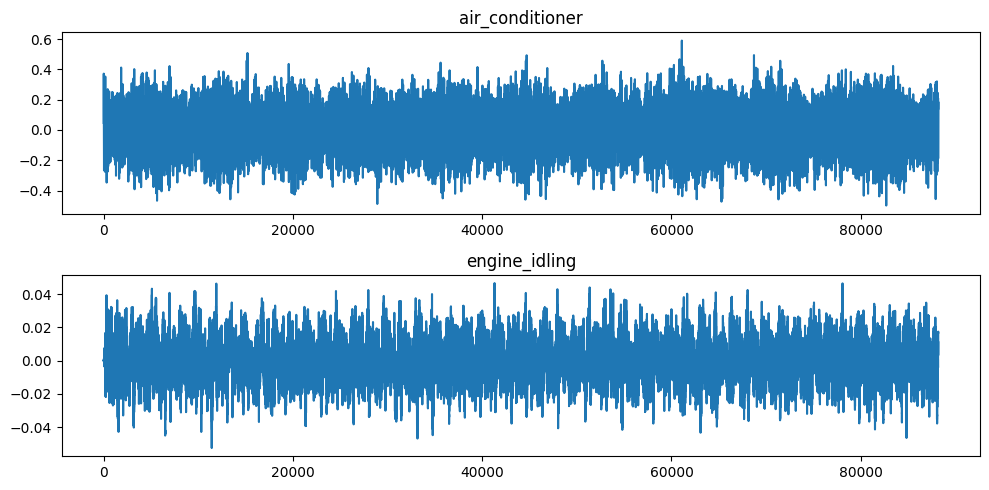

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(sample_data_1['data'])
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
plt.plot(sample_data_2['data'])
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

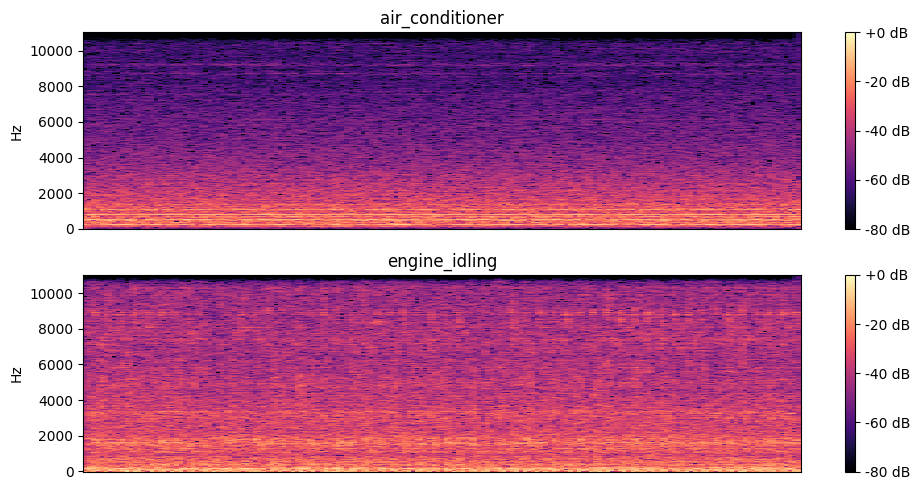

In [31]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_1['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_2['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

In [ ]:
drilling_sample_name = data[data.label == 4].iloc[0].audio
hammer_sample_name = data[data.label == 7].iloc[0].audio

sample_data_1 = folds[5][drilling_sample_name]
sample_data_2 = folds[5][hammer_sample_name]

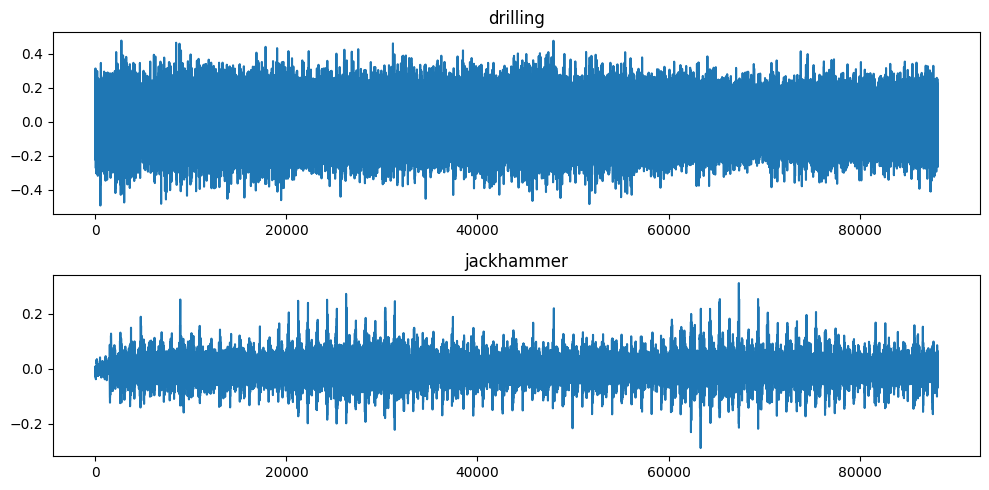

In [33]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(sample_data_1['data'])
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
plt.plot(sample_data_2['data'])
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

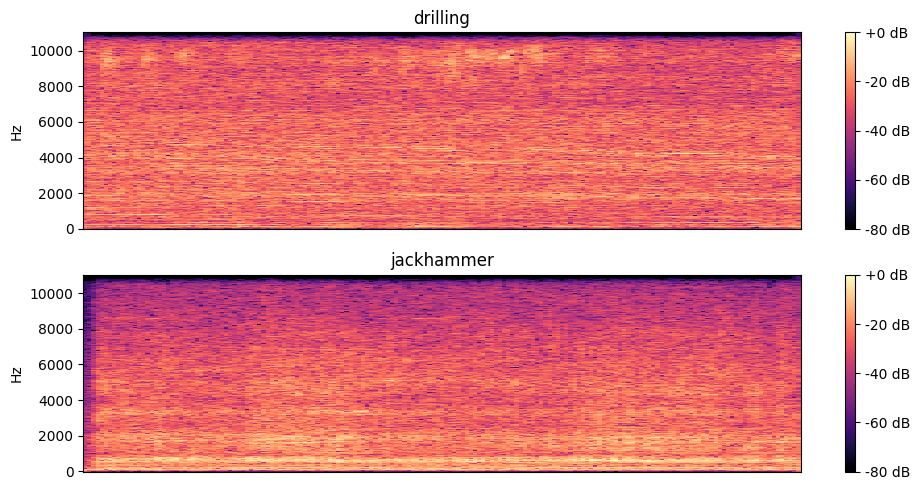

In [34]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_1['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_1['label']])

plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_2['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_2['label']])

plt.tight_layout()

In [52]:
dog_sample_name = data[data.label == 3].iloc[1].audio
children_sample_name = data[data.label == 2].iloc[0].audio
siren_sample_name = data[data.label == 8].iloc[0].audio
street_sample_name = data[data.label == 9].iloc[0].audio

sample_data_1 = folds[5][children_sample_name]
sample_data_2 = folds[5][dog_sample_name]
sample_data_3 = folds[5][siren_sample_name]
sample_data_4 = folds[5][street_sample_name]

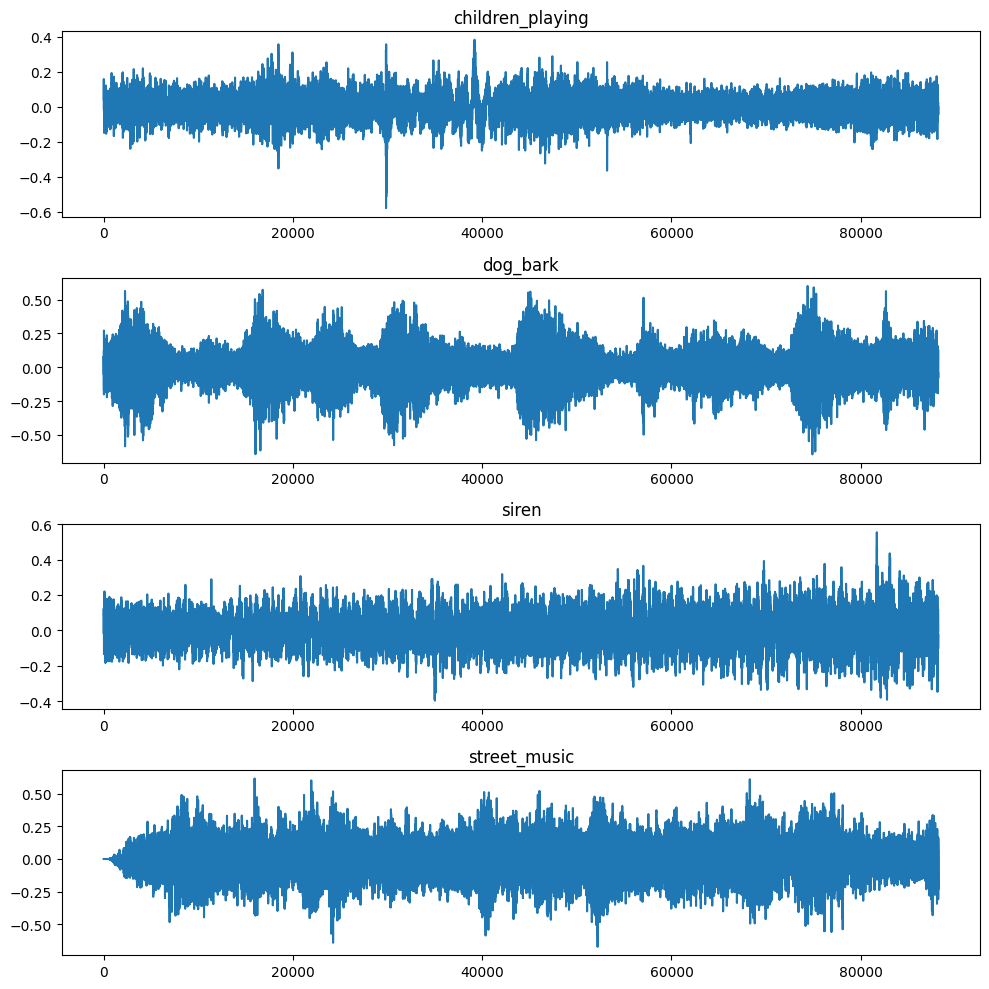

In [53]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.plot(sample_data_1['data'])
plt.title(label_dict[sample_data_1['label']])

plt.subplot(4, 1, 2)
plt.plot(sample_data_2['data'])
plt.title(label_dict[sample_data_2['label']])

plt.subplot(4, 1, 3)
plt.plot(sample_data_3['data'])
plt.title(label_dict[sample_data_3['label']])

plt.subplot(4, 1, 4)
plt.plot(sample_data_4['data'])
plt.title(label_dict[sample_data_4['label']])

plt.tight_layout()

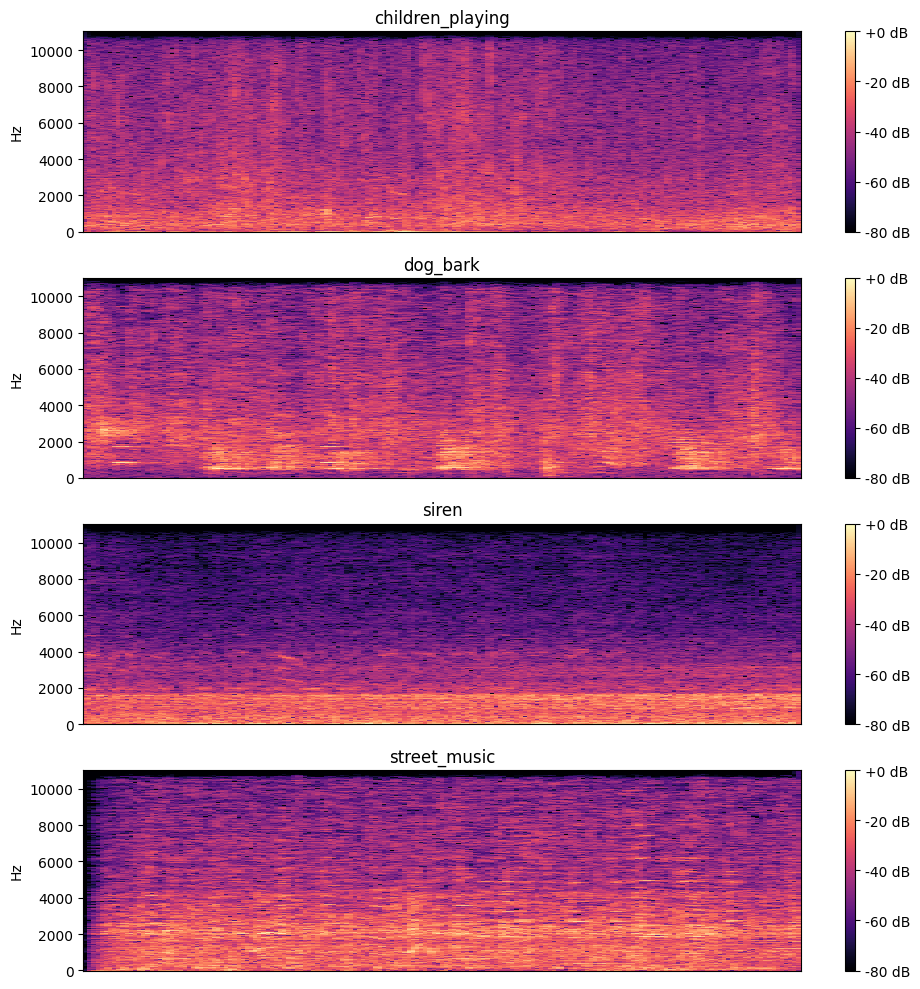

In [54]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_1['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_1['label']])

plt.subplot(4, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_2['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_2['label']])

plt.subplot(4, 1, 3)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_3['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_3['label']])

plt.subplot(4, 1, 4)
D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_data_4['data'])), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title(label_dict[sample_data_4['label']])

plt.tight_layout()